<div style="text-align: center;">

# **Algoritmia Cuantica** 
# Algoritmo de Shor  
  
<font size="2">

##### Daniel Amauri Vázquez Gutiérrez
</font>

En esta practica se hizo una investigacion sobre el funcionamiento logico detras del Algoritmo de Shore, sobre el como funciona este ultimo, brevemente se comenta sobre las limitaciones actuales del algoritmo y finaliza implementando el algoritmo para dos numeros , $N=15$ y $N=35$ . 






In [1]:
#Bloque de importacion
import numpy as np 
import math
import random
from collections import Counter
import pandas as pd


from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer #Aer es un modulo de Qiskit que proporciona simuladores cuanticos para ejecutarlos de manera local.  
from qiskit.quantum_info import Statevector,DensityMatrix
from qiskit.visualization import plot_histogram,plot_bloch_multivector
from qiskit.circuit import Gate 


import qiskit 
print(qiskit.version.get_version_info()) 

1.2.0


In [3]:
# Definir la compuerta personalizada que realiza la Transformada Cuantica 
class QFT(Gate):
    def __init__(self, s):
        # n es el numero que será representado en binario, s es el número de qubits
        super().__init__('QFT_CUSTOM', s,[])  # La etiqueta de la compuerta y el número de qubits
        self.s = s
        
       

    def _define(self):
        qc = QuantumCircuit(self.s)

        # Aplicar la Transformada Cuantica de Fourier 
        for j in range(self.s):
            qc.h(self.s - (j + 1))
            if self.s - (j + 1) > 0:
                for k in range(self.s - (j + 1)):
                    l = self.s - (j + 1) - 1 - k
                    qc.cp(2 * np.pi / (2 ** (self.s - j - l)), l, self.s - (j + 1))

        # Aplicar los swaps necesarios
        if self.s % 2 == 1:
            for l in range((self.s - 1) // 2):
                qc.swap(l, self.s - 1 - l)
        else:
            for l in range(self.s // 2):
                qc.swap(l, self.s - 1 - l)

        self.definition = qc  

In [4]:
#Transformada Cuantica de Fourier Inversa  

class IQFT(Gate):
    def __init__(self, s):
        # n es el numero que será representado en binario, s es el número de qubits
        super().__init__('IQFT_CUSTOM', s, [])  # La etiqueta de la compuerta y el número de qubits
        self.s = s
        

    def _define(self):
         qc = QuantumCircuit(self.s)
 
         #Primero volvemos a Switchear 
         if self.s % 2 == 1:
               for l in range((self.s - 1) // 2):
                  qc.swap(l, self.s - 1 - l)
         else:
               for l in range(self.s // 2):
                  qc.swap(l, self.s - 1 - l)


            #Volvemos a añadir las compuertas pero ahora en un sentido invertido 

         for j in range(self.s):  
               qc.h(j)

               if j<(self.s-1):
                  for k in range(j+1):
                     qc.cp(2*np.pi/(-2**(k+2)),j+1,j-k)   

         
            #Agragamos este SWAP que no deberia ser nesesario , sin embargo , lo ponemos dado que esto nos permite ver los estados de los Qbits en un orden
            #usal en el que vemos los numeros binarios y asi poderlo comparar con el arreglo original que producimos al inicializar el circuito. 

         
         self.definition = qc  

In [5]:
# SWAP  cumtomizado  
class SWAP(Gate):
    def __init__(self, s):
        # n es el numero que será representado en binario, s es el número de qubits
        super().__init__('SWAP_CUSTOM', s, [])  # La etiqueta de la compuerta y el número de qubits
        self.s = s
        

    def _define(self):
         qc = QuantumCircuit(self.s)
 
         #Primero volvemos a Switchear 
         if self.s % 2 == 1:
               for l in range((self.s - 1) // 2):
                  qc.swap(l, self.s - 1 - l)
         else:
               for l in range(self.s // 2):
                  qc.swap(l, self.s - 1 - l)


         
         self.definition = qc  

In [6]:
#Algoritmo de Fraccion Continua 

from fractions import Fraction

def continued_fraction(x, max_iterations=20):
    cf = []
    for _ in range(max_iterations):
        a = int(x)  # Parte entera
        cf.append(a)
        x = x - a
        if x == 0:  # Si el resto es cero, terminamos
            break
        x = 1/x  # Trabaja con fracciones para evitar errores de precisión
        if abs(x) > 1e6:  # Limita coeficientes absurdos
            print("Término anómalo detectado:", x)
            break
    return cf
    
   

def approximate_fraction(cf):
    """Toma los coeficientes de una fracción continua y devuelve la aproximación como una fracción."""
    n = len(cf)
    
    # Manejo especial si la fracción continua es muy pequeña
    if n == 0:
        return Fraction(0)
    
    # Inicializamos con la última fracción (el último término)
    frac = Fraction(cf[-1])
    
    # Empezamos a recorrer los términos de la fracción continua en orden inverso
    for a in reversed(cf[:-1]):
        frac = a + 1 / frac
    
    return frac



Siguiendo con lo antes aprendido en la **practica $7$**, una subrutina en el algoritmo de Shore es el *Quantum Period Finding* , que como veremos mas adelante  expanderemos a periodos de mas de $2$.  Ademas comentamos de forma anticipada que uno de los principales retos  en este algoritmo sera el crear un **Oraculo** $U_o$  para los modulos  de algun valor $N$ que elijamos. 

Antes de crear nuestro Oraculo ,  hay que entender, ¿Por que este algoritmo nos es util en el algoritmo de Shore?, y aun más, ¿Qué es el algoritmo de Shore y cual es su fin?. 

## **Usos y ventajas del Algoritmo de Shore**

Pues bien , el **Algoritmo de Shore** es un algoritmo cuántico para descomponer en factores un número $N$, cuya caracteristica principal es que tiene un *tiempo computacional* de $O((\log(N))^3)$ y un *espacio computacional* de $O(\log(N))$, para entender por que es relevante esto primero hay que entender que es el *tiempo computacional* y el *espacio computacional*. 

+ **Tiempo computacional**: Es una medida de cuántos pasos o "operaciones elementales" (como sumas, multiplicaciones, comparaciones, etc.) realiza un algoritmo mientras se ejecuta. En general, el tiempo computacional se expresa como una función de $n$, el tamaño de la entrada en bits, y se usa la notación Big-O para dar una cota superior asintótica. Esto indica cómo crece el tiempo de ejecución cuando el tamaño de la entrada aumenta. 

+ **Espacio computacional**: Es una medida de cuánta memoria utiliza un algoritmo mientras se ejecuta. También se expresa en términos del tamaño de la entrada y utiliza notación Big-O para describir el comportamiento asintótico. El espacio computacional incluye todas las variables y estructuras de datos que el algoritmo necesita almacenar temporalmente para completar su tarea. 


Tambien es importante recalcar que un numero $N$ puede ser representado con un numero de entradas o bits $n$, donde la relacion entre $N$ y $n$ esta dada por : 

$$ n=\log_{2}N + 1$$ 

Ej.  Si $N=8$ entonces $n=\log_{2}8 + 1 =4$. Dado que $8_{10} = 1000_2$ , entonces la formula es testeada .  

Añadimos que en general  en las complejidades  del tiemnpo y espacio computacional ,  el numero de memoria o tiempo puede ser mayor , pero el representado es el *factor mas representativo* . 

Dicho lo anterior , investigamos el tiempo computacional que emplea el algoritmo clasico mas eficas para factorizar algun numero $N$ y este tiene un tiempo computacional:    

$$O\left(e^{(64/9)^{1/3} (\log N)^{1/3} (\log \log N)^{2/3}}\right)$$





Que es el tiempo computacional de el Algoritmo de Criba de Campos de Números General (General Number Field Sieve, o GNFS). Este es el método clásico más eficiente conocido para la factorización de números enteros grandes y es ampliamente utilizado para intentar factorizar números grandes en el ámbito de la criptografía. 

Tiene complejidad subexponencial (*La complejidad subexponencial está entre la complejidad polinómica y la exponencial. Un algoritmo se considera de complejidad subexponencial si su tiempo de ejecución es más lento que cualquier función polinómica, pero más rápido que una función exponencial.*), que hace que sea más rápido que otros métodos clásicos para factorización, pero sigue siendo mucho más lento que el tiempo polinómico del algoritmo de Shor.

## **Teoria** 

Por lo anterior , nuestra motivacion con este algoritmo  la eficiencia que podemos llegar a tener en tiempo de ejecucion para factorzar numeros.  

### **Algebra de modulos de numeros enteros** 

Veamos observemos el siguiente comportamiento:

\begin{gather*}
x\equiv 1\mod N \\
x-1\equiv 0\mod{N}\\
\rightarrow (x-1)=K\cdot N
\end{gather*} 
Con $K \in \mathbb{N}$. 

#### **Inversibilidad modular** 



Para que un numero $x$ sea invertible  modulo $N$, debe existir otro numero $x^{-1}$ tal que : 
$$x\cdot x^{-1}\equiv 1 \mod N $$ 

Ejemplo : 
Sea $x=3$ , entonces con $N=8$ , $x^{-1}=3$ , ya que :
$$x\cdot x^{-1}=3 \cdot 3 = 9 \equiv 1 \mod 8 $$ 





#### **Factorizacion Modular** 

Por otra parte sean $z=u \cdot g$, luego:

$$  z \mod N = ((u \mod N)(g \mod N))\mod N$$


#### **Periodicidad  Modular**   



Decimos que la Funcion modular es periodica , cuando se cumple lo siguiente:  

$$f(a)=x^a \mod N \equiv x^{a+K\cdot r} \mod N = f(r+K\cdot r) $$ 

Un caso particular dentro de este , y que nesesariamente va a ocurrir por la *factorizacion modular* es el de : 

$$x^r \equiv 1\mod N $$

Cuando esto sucede , decimos que $r$ es el orden del $x$ elegido y entonces :

$$x,x^2,x^3,...,x^r$$ 

Son distintos modulos N . 

Notemos que esto implica de forma implicita que **el $x$ elegido posee un inverso multiplicativo modular $x^{-1}$**. Por otra parte quiero hacer incapie en a que conjunto pertenecen los $x$ para los que esto es valido, ya que no basta con pertenecer al conjunto $\mathbb{Z}/N\mathbb{Z} $ que es el  conjunto de residuos de N. 
Veamos  un ejemplo para darnos cuenta de esto : 

Para $N=8$ : 

$$ \mathbb{Z}/N\mathbb{Z}={0,1,2,3,4,5,6,7}$$

Observa que no existe $x \in  \mathbb{Z}/N\mathbb{Z} $ tal que :  

$$ 2\cdot x \equiv 1 \mod 8 $$ 

Por lo que $2$  no tiene inverso multiplicativo y por lo tanto no podemos obtener periodicidad al obtener las potencias de este. 


Con este ejemplo entonces nos podemos preguntarnos , **¿Que condicion tiene que tomar una $x$ para que podamos encontrarle una periodicidad modular y porlo tanto un orden $r$ ?** 

La respuesta a esto es exigir  que $x\in (\mathbb{Z}/N\mathbb{Z})^* $  donde este conjunto es llamado *Grupo Multiplicativo* de los residuos de N. Definiendolo de la siguiente forma: 

$$(\mathbb{Z}/N\mathbb{Z})^* =\{x\in \mathbb{Z}/N\mathbb{Z}| \gcd(x,N)=1\}$$ 

Que en otras palabras , son los elementos de residuos de N , que ademas son **coprimos con  el propio N**. Analizando esto , podemos ver que como nuestros $x$ ahora elegidos son siempre coprimos, estos siempre podemos garantizar que  tienen inverso modular $x^{-1}$ .  

Demostracion :  

Por definicion 



\begin{gather*}
x\cdot x^{-1} \equiv  1\mod N \\
\rightarrow x\cdot x^{-1}- k\cdot N =  1 \\

\end{gather*} 
Con $k \in \mathbb{N}$. 

Si $x$ y $N$ conpartieran un factor comun $d>1$, $Y= x\cdot x^{-1}- k\cdot N $ seria divisible por d , ya que tanto $x$ como $N$ son divisibles por $d$  . Sin embargo , esta claro que al tratarse de enteros , $d$ no puede dividir a 1. 

Por lo tanto para tener inversos modulares , forzosamente  $x\in (\mathbb{Z}/N\mathbb{Z})^* $ . 

### **Exponenciacion Modular:** 

Recordemos que nosotros no vamos a estar trabajando con numeros decimales, sino con numeros binarios , $0$ y $1$ , por lo que es importante rememorar que para cualquier entero  $\chi$ , podemos :  

$$\chi |_{10} \equiv \chi_{t-1}\chi_{t-2}...\chi_{1}\chi_{0} |_2 $$

Donde $\chi_w \in [ 0,1]$ donde $w \in [ 0,t-1]$ y $t$ es en numero de digitos de $\chi$ en binario. Luego:  

$$\chi |_{10} = \chi_{t-1}2^{t-1}+\chi_{t-2}2^{t-1}+...+\chi_{1}2^{1}+\chi_{0} 






Ahora , antes de encontrar  nuestro periodo $r$ , habra que conocer que valor de varios :

$$ x^a \mod N = x^{a_{t-1}2^{t-1}+a_{t-2}2^{t-1}+...+a_{1}2^{1}+a_{0} }\mod N $$

Donde: 

$$a=a_{t-1}2^{t-1}+a_{t-2}2^{t-2}+...+a_{1}2^{1}+a_{0} \qquad a \in [0,r]$$  



**Nota de esta seccion**: Durante el Codigo, veremos que nuestros *Qbits de estimacion* seran usados para representar todos los valores que pueden tener  $a$ , mientras que nuestros *Qbits de apoyo* se emplearan para crear una compuerta cuantica que represente  el modulo de algun numero especifico $x$ . [Esto siguiendo  la nomeglatura empleada en la sección]

Para esto existe un algoritmo clasico super eficiente llamado *Algoritmo Euclidiano* el cual puede calcular el $\gcd$ en tiempo polinomico, lo cual es muy aceptable como vimos anteriormente. Este algoritmo lo retomaremos mas adelante. 





## **Algoritmo de Shore**  
Nuestro objetivo sera entonces que si queremos factorizar algun numero $N$ en factores primos $p$ y $q$ , tal que : 

$$ N=p \cdot q $$

Por lo que al comienzo  elegimos un  numero $N$ que querremos factorizar, luego  para **$x$ aleatorias** tales que $x\in (2,N-2) $, usando el *Algoritmo de Euclides* encontramos :

$$ u= \gcd (x, N)$$  

Si $u>1$ , entonces  hemos encontrado uno de los factores de descomposicion de N , por lo que :

\begin{gather*} 
p= u \\
q=N/u 

\end{gather*}  

Sin embargo esto no va a ser lo usual , por lo que ahora nos enfocaremos cuando $u=1$, es decir $x$ y $N$ son coprimos. 

Nuestra tarea sera ahora encontrar el orden $r$ de nuestro $x$ elegido , esto es : 

$$x^r \mod{N}\equiv 1\mod{N}$$  

Y  para lograr esto  emplearemos el algoritmo *Quantum Period Finding* . Ademas ,  aclarando  que  todo numero $x$  es  Raiz cuadrada *no tribial* ( es decir , $x \neq 1$ ) tiene la forma : 

$$ x^2 \equiv 1\mod N   \qquad x\in (2,N-2)$$



Exijimos ademas que nesesariamente $r$  tiene que se **par** ,$r= 2s$, con lo que podemos hacer la siguiente operacion :  

\begin{gather*}
x^r=(x^{s})^2\equiv 1 \mod{N} \\
(x^{s})^2-1 \equiv 0\mod{N} \\
\rightarrow (x^s-1)(x^s+1)=K\cdot N  
\end{gather*}


Por lo que $(x^s-1)(x^s+1)$ es un entero que tiene como factor a $N$, por lo que o $(x^s-1)$ o $(x^s+1)$ no es un multiplo de $N$,y ademas alguno de estos ebe de tener un factor comun con $N$. 

Obtenemos entonces : 

$$v = \max\left(\gcd(x^s-1, N), \gcd(x^s+1, N)\right)$$ 


Por lo tanto : 

\begin{gather*} 
p= v \\
q=N/v 

\end{gather*}  

### **Oraculo**  

En esta seccion hablaremos especificamente de lo que , personalmente mas me rompio la cabeza  y la razon por la cual se extendio tanto la parte Teorica de esta practica. 

El mayor reto entonces , es conseguir un oraculo que sea capas de calcular : 

$$ f(a)= x^a \mod N  $$

Y que el diseño eficiente de este , que se resume a el que tenga la profundidad ( *cantidad  de compuertas cuanticas aplicadas maximo que algun qbit debe atravesar  en el circuito* ), ya que esto hara que se minimice lo maximo posible la decoherencia que pueda tenerse.  


La creacion de estos oraculos son , en la mayor de los casos mas simples que se han logrado por el momento , artesanales  y con conocimiento apriori de los numeros coprimos que de un cierto numero $N$ y cabe recalcar que para cuando se escribe esta practica, el numero mas grande factorizado es $N=35$, debido tanto a la limitacion de la creacion de Oraculos como por el  numero limitado de qbits en las computadoras cuanticas actuales ( *2024*)  . 

Pero , ¿que  posibilidades hay de mejorar esta situacion ? ¿ Que otras posibilidades hay para la creacion de oraculos para el algoritmo de Shore?   

Ademas de minimizar la cantidad de compuertas cuanticas y qbits utilizados , exisiten algunas ideas que se han estado trabajando los ultimos años : 

- Aritmetica Cuantica Optimizada : 

     Se han propuesto variantes del algoritmo de Shor que optimizan las operaciones aritméticas. Por ejemplo:

    - Adiciones y multiplicaciones cuánticas más rápidas: Implementaciones de circuitos para la suma y multiplicación modular que minimizan los costos en términos de puertas Toffoli y CNOT.
    - Algoritmos de multiplicación asimétrica: Métodos que explotan las propiedades del número $N$ o del coprimo $a$ para simplificar las operaciones.  

- Uso de estructuras precomputadas (clásico-cuántico híbrido)
    Se pueden precomputar ciertas partes del oráculo clásicamente y aprovechar esa información durante la ejecución cuántica. Por ejemplo:

    - Reducción del trabajo cuántico: Calcular ciertas potencias o combinaciones $x^a \mod N$ de manera clasica, almacenarlas, y usarlas para simplificar el calculo cuantico. 
    - Aproximaciones: Para casos específicos, usar aproximaciones que reduzcan la complejidad del cálculo sin comprometer significativamente la funcionalidad del oráculo. 

- Métodos semicuánticos
    Los métodos híbridos permiten dividir el problema entre recursos clásicos y cuánticos. Ejemplo:

    - Particiones del espacio de búsqueda: Calcular partes del problema clásicamente, como identificar coprimos o descomponer el espacio de búsqueda, para reducir la carga cuántica.
    - Técnicas de compilación adaptativa: Ajustar el diseño del oráculo en función de las características específicas del problema. 

- Alternativas al oráculo estándar
    Algunas investigaciones han explorado cómo redefinir el oráculo o sustituirlo por métodos alternativos:

    - Aproximaciones en el cálculo modular: Usar versiones aproximadas de $f(a)= x^a \mod N$ que sean más fáciles de implementar pero suficientemente precisas para detectar la periodicidad.
    - Redes tensoriales o métodos de simulación: Representar $f(a)$ con métodos alternativos, aunque estas ideas están más en el ámbito experimental y teórico.

- Propuestas teóricas y experimentales recientes
    - Reducción de la profundidad de circuitos: Avances recientes en técnicas como la codificación QROM (Quantum Random Access Memory) han reducido la profundidad de circuitos para oráculos específicos.
    - Implementación en hardware específico: Se han investigado arquitecturas cuánticas adaptadas a la aritmética modular, como sistemas superconductores y trampas de iones optimizados para estos cálculos.
    - Factorización semi-clásica: En lugar de implementar completamente el algoritmo de Shor, usar técnicas como algoritmos de factorización clásica combinados con búsquedas cuánticas.

## **Implementacion** 

En esta seccion implementaremos toda la teoria vista antes, primero para un numero que es extensamente empleado para ejemplificar este algoritmo, $N=15$ .

Posteriormente, despues de obtener parcialmente el Oraculo de $N=35$ , lo emplearemos para revisar nuestros resultados. 

### **Oraculo de nuestros numeros $N$ objetivo**

Partimos definiendo oraculo para $N=15$ , en el que como vimos , nos enfocamos en los numeros  coprimos  de 15,  $a$ , tales que  $a \in [ \{ 2, 15-2 \}\land \{\gcd(a,15)=1\}] $ que son : 

$$\{2,4,7,8,11,13\}$$  



Para estos tenemo el oraculo especifico para cada uno de los numeros coprimos  de 15. Ahora veamos el caso de $N=35$ donde vemos que sus coprimos sin contar los multiplos de estos , son : 

$$\{ 2,3,11,13,17,19,23,29,31\} $$ 

No contamos los multiplos de estos por que podriamos deducir  estos apartir de sus operaciones modulares que ya tenemos. 

El reto aqui fue de lo mas interesante. Todas las compuertas puestas aqui son invencion del autor ; Evidentemente esto hace que no sean para nada optimizadas y que probablemente haya muchisimo que mejorar con estas, sin embargo a nivel teorico funcionan. No se pudo deducir todas, ya que para numeros como el 2,3,17 y 23  el periodo es de 12, haciendo que el obtener su Oraculo $U_o$ sea una tarea algo extenuante, y que hasta donde pude intentarlo, produce oraculos produndos. 

El como se consiguieron las operaciones modulares es completamente artesanal , y como se observa , la aplicacion es por casos, de donde se deduce que ya uno tiene que ser conciente de cual sera el resultado  en todas las posibles situaciones.  Para mas claridad de esta parte y de por funciona , al final de esta practica se deja  algunas imagenes  de este oraculo y se pide al lector que intente hacer las operaciones a mano para mayor claridad. 

In [7]:
#Oraculo 

def c_xmodN(N,n, x, power):
    if N==15:
        """Multiplicacion controlada  en  mod 15 
        
        Cuando se seleccione un cierto valor 'a' , entonces  cada que se aplique esta compuerta con ese valor de 'a'
        se mutiplicara una vez mas 'a' . 

        Si se multiplica a 1 , a veces esta compuerta tendremos :
                    
                x^a mod N   
        """
        if x not in [2,4,7,8,11,13]:
            raise ValueError("'x' debe ser 2,4,7,8,11,13") 
        
        U = QuantumCircuit(n)
        for _iteration in range(power):
             
            if x in [2,13]:
                U.swap(2,3)
                U.swap(1,2)
                U.swap(0,1)
            if x in [7,8]:
                U.swap(0,1)
                U.swap(1,2)
                U.swap(2,3)
            if x in [4, 11]:
                U.swap(1,3)
                U.swap(0,2)
            if x in [7,11,13]:
                for q in range(4):
                    U.x(q)
             
        U = U.to_gate()  #Convierte un operador unitario U (definido previamente) en una puerta cuántica (QuantumGate). 

        U.name = f"{x}^{power} mod 15"   #Asigna un nombre descriptivo a la puerta U 

        c_U = U.control()  #Crea una versión controlada de la puerta  U. Una puerta controlada se activa solo cuando el qubit de control está en el estado |1>

        return c_U

    elif N==35:
         #Multiplicacion controlada  en  mod 35 
         
         if x not in [11,13,29,31]:
            raise ValueError("'x' debe ser 11,13,29,31")
         U = QuantumCircuit(n)
         for _iteration in range(power):
            if x==11:
                U.cx(3,4)
                U.cx(0,1)
                U.cx(0,3)
                U.x(0)
                U.ccx(0,4,5)
                U.x(0)
                U.cswap(5,0,4)
                U.x(4)
                U.x(3)
                U.mcx([0,3,4],5)
                U.x(3)
                U.x(4) 
                U.cx(4,0) 
            if x==13:
                U.ccx(4,1,0)
                U.cx(3,0)
                U.cswap(4,2,1)
                U.ccx(2,3,4)
                U.cx(0,2)
                U.cx(0,3)
                U.mcx([3,4],0)    
            if x==29:
                for q in range(3):
                    U.cx(0,q+2)   
            if x==31:
                for q in range(2):
                    U.x(q)
                U.mcx([0,1],5)
                for q in range(2):
                    U.x(q)
                U.cswap(5,2,4)
                for q in range(2):
                    U.x(q)
                U.mcx([0,1],5)
                for q in range(2):
                    U.x(q)

                U.x(3)
                U.mcx([3,2],1)
                U.x([3,1])
                U.mcx([1,2],5)
                U.x(1)
                U.cswap(5,1,2)
                U.x([3,2])
                U.mcx([1,2,3],5)
                U.x([3,2])

                U.x([0,2])
                U.mcx([0,1,2,3],4)
                U.x([0,2])
                for q in range(4):
                    U.cx(4,q)
                U.x([0,2])
                U.mcx([0,1,2,3],4)
                U.x([0,2])

                U.x([4,2])
                U.mcx([4,1,2,3],0)
                U.x([4,2])
                for q in range(4):
                    U.cx(0,q+1) 
                U.x([4,2])
                U.mcx([4,1,2,3],0)
                U.x([4,2])

                U.x(2)#recuerda revertirlo al final
                U.mcx([1,2],0)
                U.x(0)
                U.mcx([0,1,2,3],4)
                U.x(0)
                U.mcx([0,1,2],3) 
                
                U.x(3)
                U.mcx([0,2,3],5)
                U.cx(5,4)
                U.cx(5,1)
                U.mcx([0,2,3],5)
                U.x(3)
                U.x(2)

                
         U = U.to_gate()  #Convierte un operador unitario U (definido previamente) en una puerta cuántica (QuantumGate). 

         U.name = f"{x}^{power} mod 35"   #Asigna un nombre descriptivo a la puerta U 

         c_U = U.control()  #Crea una versión controlada de la puerta  U. Una puerta controlada se activa solo cuando el qubit de control está en el estado |1>

         return c_U
    else:
        raise ValueError("No se ingreso un numero N valido")

Teniendo nuestro Oraculo $U_O$ creado , ahora  le pedimos al usuario que ingrese un numero , sea 15 o 35 a ser factorizado.

In [8]:
#Eleccion de numero. N=35|| N=15

while True:
    try:
        N = int(input("Ingresa un número (15 o 35): "))
        if N in [15, 35]:
            break  # Salir del bucle si el número es válido
        else:
            print("Número inválido. Intenta de nuevo.")
    except ValueError:
        print("Entrada no válida. Por favor, ingresa un número.")

print(f"Has ingresado el número {N}.")

Has ingresado el número 15.


Como habiamos establecido , se elige un numero aleatorio $x \in \{2, N-2\} $,tanto para que sea posible que $x$ sea un factor de $N$ como para que exista la posibilidad de *raices cuadrada modulares no tribiales*.

Despues nos preguntaremos si este numero es coprimo de nuestro $N$ , de no serlo usamos algoritmo de Euclides , de serlo procedemos con el *Quantum Period Finding*  (*En el caso de $N=35 como no tenemos el oraculo de todos los coprimos , reiteraremos la seleccion de un $x$ que se acomode a nuestras nesesidades) , si resulta que el periodo es impar , tambien seleccionamos otro numero $x$ .  

Recordemos que nuestros Qbits de apoyo son los que codificaran a $x$ y sus modulos .  


Solo hare algunas acclaraciones para la  factorizacion del $N=35$  en el codigo que seguira a continuacion: 

* Puede tardarse muchisimo mas para algunos valores de $x$  
* En la facorizacion de 35 , para ciertos valores de $x$, sus oraculos al se algo profundos, provocan que se generen algunas decoherencias, por lo que al momento de hacer las cuentas y el histograma, puede que aparezcan que no nos interesan , sin embargo aun asi conseguimos buenos picos en los numeros que nos interezan. 

El autor encontro dos mecanismos para disminuir los estragos que nos pueden provocar estas dos situaciones :

* Apartir del numero con mayor numero de cuentas obtenido , solo contamos cierto porcentaje de este como minimo para poder utilizarlo.  
* Podemos modificar el numero de qbits de estimacion  a un numero entre $s$ y $t=2s$ con $s$ en numero de qbits de apoyo. Funciona, aun que no tengo argumentos matematicos para saber por funciona( Un que tampoco los encontre para que los qbits de estimacion tengan que ser minimo el doble de los de apoyo. )

Aplica **varias veces** el algoritmo si es nesesario para que se emplee la parte cuantica. 

In [9]:
# Algoritmo de Shore 
while True:
    x=random.randint(2,N-2) # Elegimos algun valor entre 2 y N-2

    print(f"Se selecciono  {x}, entre 2 y {N-2}.")

    d=math.gcd(x,N) 
    if d>1: #Opcion 1 : No son Coprimos // tienen un maximo comun multiplo mayor a 1
        p=d
        q=N/d  
        print(f"Factorizacion de {N} encontrada : q={q} y p={p} .") # Sin uso de la computacion cuantica 
        print(f"Sin uso de Computacion Cuantica para la factorizacion")
        break
    
    elif (N==15 and x not in [2,4,7,8,11,13]) or (N==35 and x not in [11,13,29,31]):  #Opcion 2 :  Se selecciono un Coprimo que no esta configurado 
        print(f"x={x} no es valido para N={N}, seleccionamos otro numero ")
        continue

    else:
        #Implementacion del circuito cuantico 
        # Creamos un circuito cuantico que tenga  la cantidad de qbits apropieada en binario, asi como especificando nuestros qbits de apoyo y de  estimacion
        
        n=math.ceil(math.log2(N)) #Nuestro numero de qbits de apoyo , donde se ejecutara las operaciones modulares.  

        '''
        
        PUEDES EDITAR AQUI LOS QBITS DE ESTIMACION 

        '''

        t=2*n #Numero de qbits de estimacion 






        print(f"Numero de Qbits de apoyo {n}")
        print(f"Numero de Qbits de Estimacion {t}")
        #Sabemos por el Quantum period Finding que requerimos que los qbits de estimacion sean el doble que los de apoyo . 


        qc = QuantumCircuit(t+n, t) #solo mediremos los qbits de estimacion 

        # Incializamos los qbits de estimacion  qubits en  |+>

        for q in range(t):
            qc.h(q)

        # Dejamos el primer qbit de apoyo en  |1> para que pueda inciar el oraculo, recuerda que el qbit 2*n es el primero de los de apoyo
        qc.x(t) 

        # Hacemos operaciones controladas 
        for q in range(t):
            qc.append(c_xmodN(N,n,x, 2**q),
                    [q] + [i+(t) for i in range(n)]) 


        # Aplicamos QFT inversa
            
        qc.append(IQFT(t), range(t))  


        # Medimos el circuito
        qc.measure(range(t), range(t)) 

        #------Obtencion del histograma ----------------
        aer_sim = Aer.get_backend('aer_simulator')

        t_qc = transpile(qc, aer_sim)

        counts = aer_sim.run(t_qc).result().get_counts()

       

        # ------Cuentas-----------------
        from fractions import Fraction

        percentage_threshold = 0.1  # Porcentaje del mayor conteo (10% en este caso)

        rows, measured_phases = [], []
        max_count = max(counts.values())  # Obtener el mayor valor de counts

        for output in counts:
            if counts[output] >= percentage_threshold * max_count:
                decimal = int(output, 2)  # Convertir cadena binaria a decimal
                phase = decimal / (2**t)  # Obtener eigenvalor correspondiente
                measured_phases.append(phase)
                
                # Calcular la fracción y la suposición para r
                frac = Fraction(phase).limit_denominator(15)
                guess_for_r = frac.denominator
                
                # Agregar valores a las filas
                rows.append([
                    f"{output}(bin) = {decimal:>3}(dec)",
                    f"{decimal}/{2**(t)} = {phase:.2f}",
                    counts[output],
                    f"{frac.numerator}/{frac.denominator}",
                    guess_for_r
                ])

        # Ordenar las filas por el valor de `Cuentas` en orden descendente
        rows.sort(key=lambda x: x[2], reverse=True)

        # Preparar un DataFrame para mostrar todas las columnas
        encabezados = ["Salida del Registro", "Fase", "Cuentas", "Fracción", "Suposición para r"]
        df = pd.DataFrame(rows, columns=encabezados)

        print(df)

        # Obtener la columna 'Suposición para r' como una lista
        valores_suposicion_r = df["Suposición para r"]

        # Contar la frecuencia de cada valor de 'Suposición para r'
        conteo_r = valores_suposicion_r.value_counts()

        # Identificar el valor de 'r' más repetido
        r = conteo_r.idxmax()  # Encuentra el valor más frecuente
        conteo_mas_repetido = conteo_r.max()  # Encuentra cuántas veces aparece

        print(f"El período 'r' más repetido es: {r} (repetido {conteo_mas_repetido} veces)")


        # Devuelve la fase más común
        print(f"La fase aproximada más repetida es: {r}")

        if r%2==0:
            u1=x**(r/2)+1
            u2=x**(r/2)-1
            d = max(math.gcd(int(u1), N), math.gcd(int(u2), N))
            p=d
            q=N/d  
            print(f"Factorizacion de {N} encontrada : q={q} y p={p} . QW") # Uso de la computacion cuantica 
            print(f"Empleamos Computacion Cuantica para la factorizacion")
            break 
        else:
            print("La fase encontrada es Impar, volvemos a buscar")
            continue 

       

            
      


        



Se selecciono  7, entre 2 y 13.
Numero de Qbits de apoyo 4
Numero de Qbits de Estimacion 8
        Salida del Registro            Fase  Cuentas Fracción  \
0  11000000(bin) = 192(dec)  192/256 = 0.75      265      3/4   
1  00000000(bin) =   0(dec)    0/256 = 0.00      258      0/1   
2  10000000(bin) = 128(dec)  128/256 = 0.50      252      1/2   
3  01000000(bin) =  64(dec)   64/256 = 0.25      249      1/4   

   Suposición para r  
0                  4  
1                  1  
2                  2  
3                  4  
El período 'r' más repetido es: 4 (repetido 2 veces)
La fase aproximada más repetida es: 4
Factorizacion de 15 encontrada : q=3.0 y p=5 . QW
Empleamos Computacion Cuantica para la factorizacion


Ahora podemos visualizar la parte Cuantica del codigo , si es que se requirio , en los siguientes dos lineas de codigo 

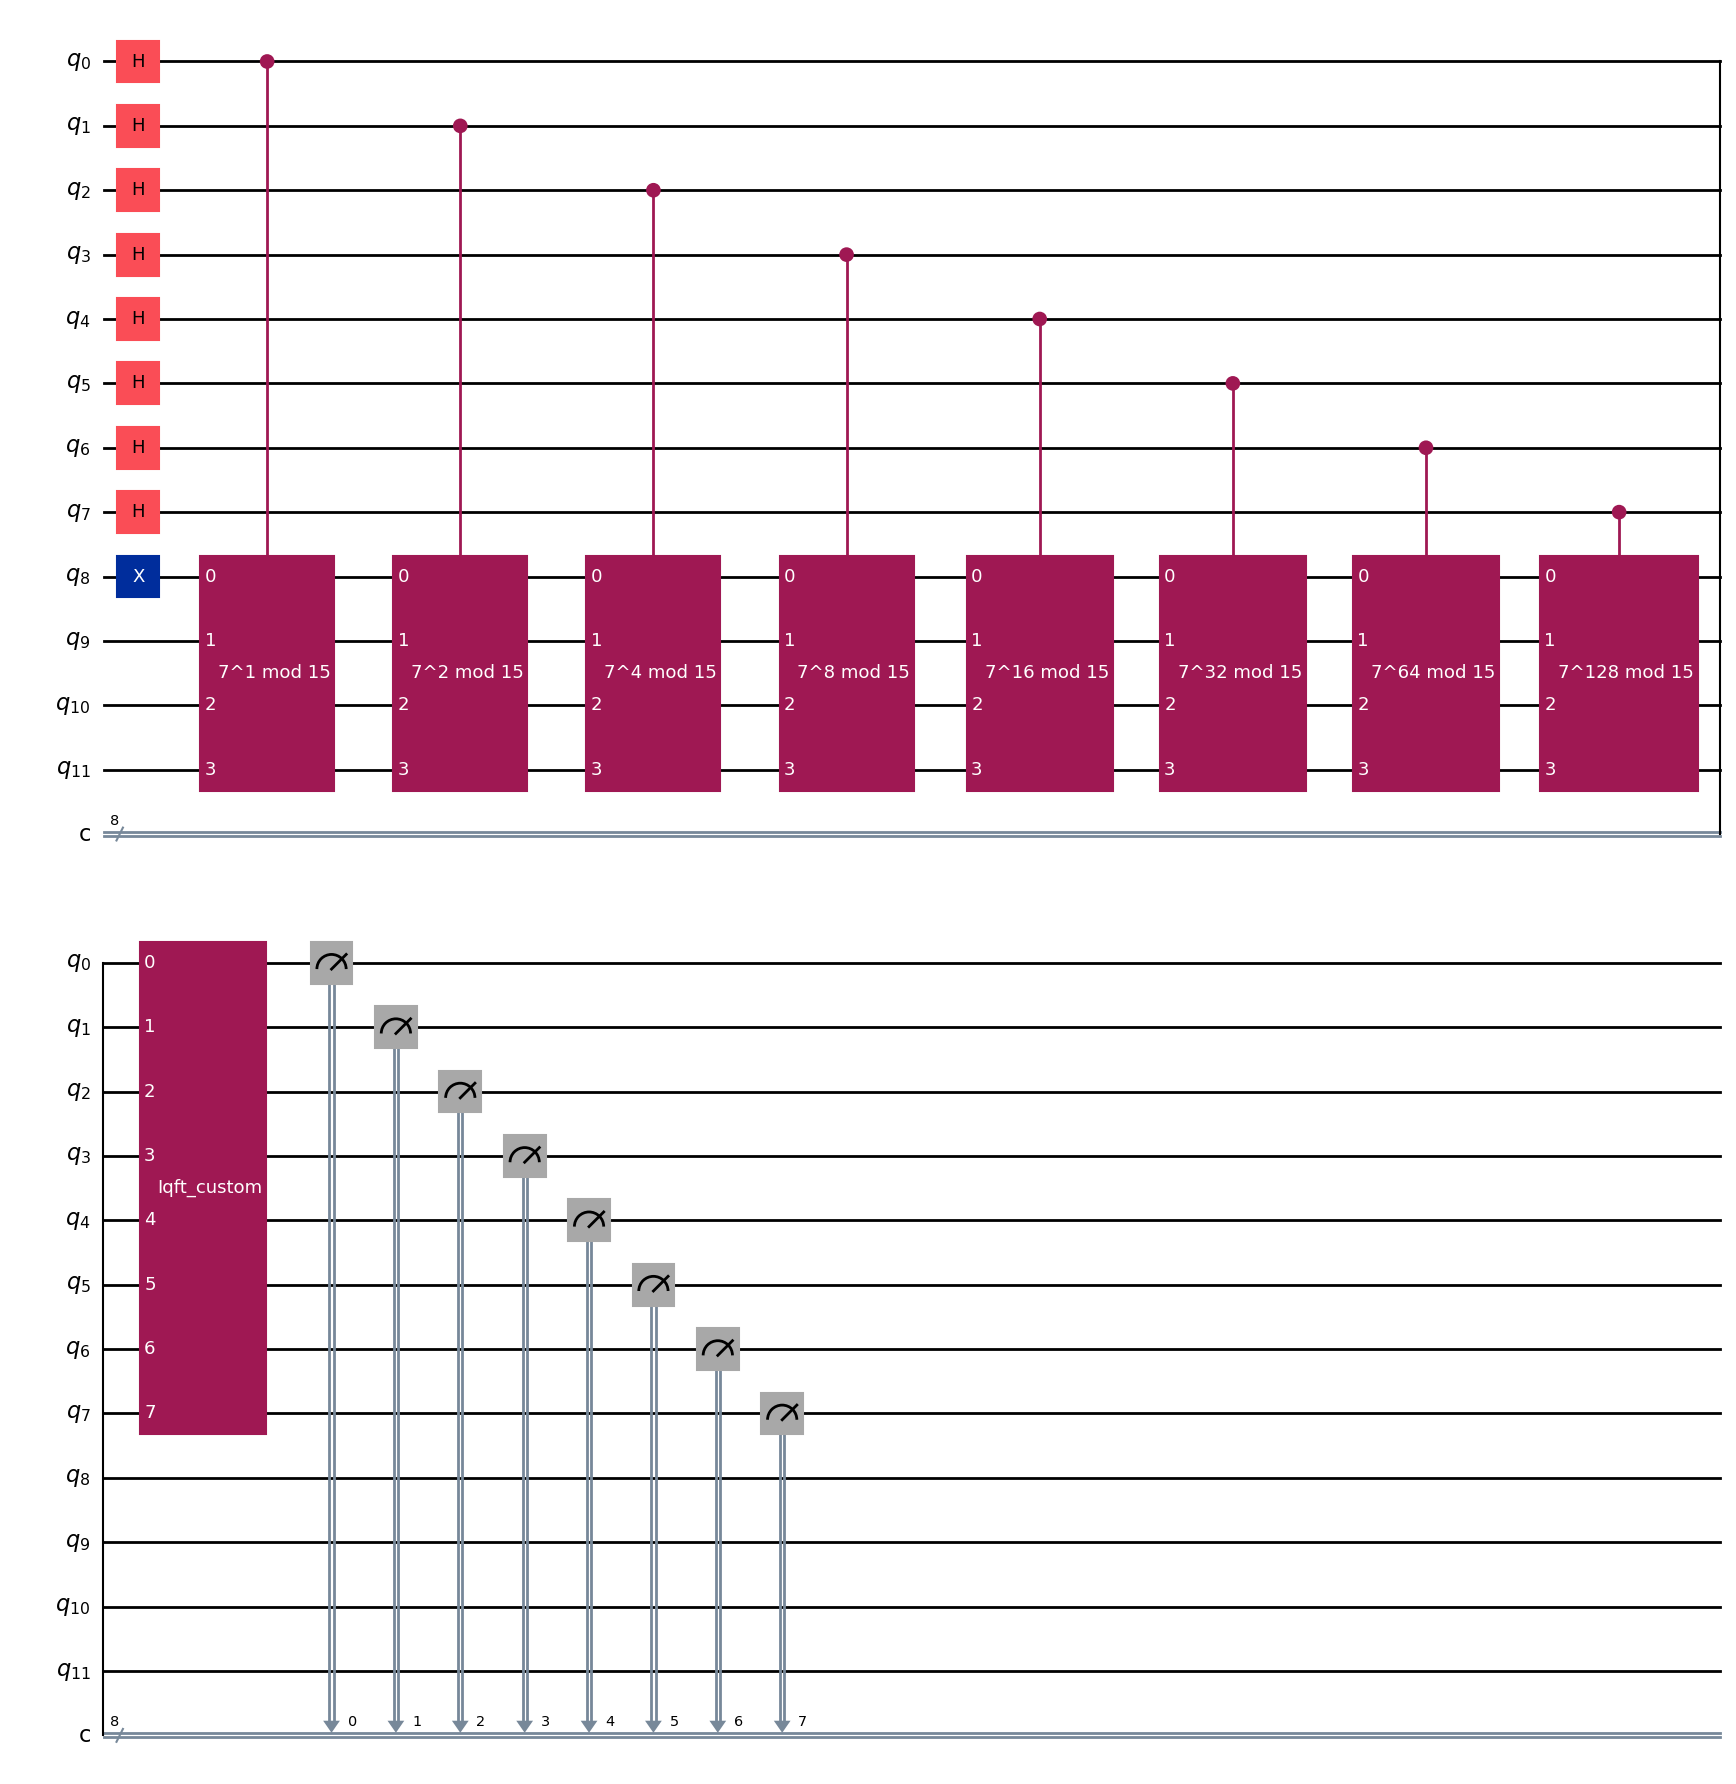

In [10]:
#Circuito cuantico grafico
qc.draw('mpl')

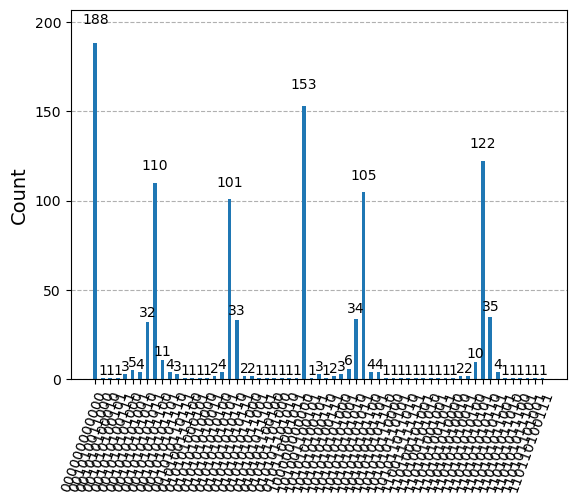

In [161]:
#Cuentas Obtenidas
plot_histogram(counts)

## **Apendice** 

Esquemas para la creacion de oraculos : 

### **N=15** : 

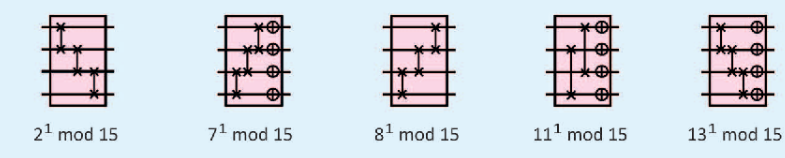

### **N=35**

### x=11  

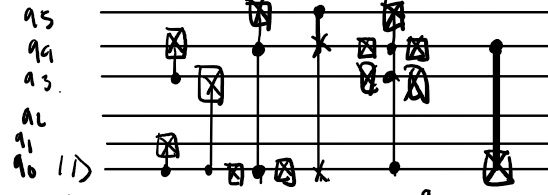 

### x=13  

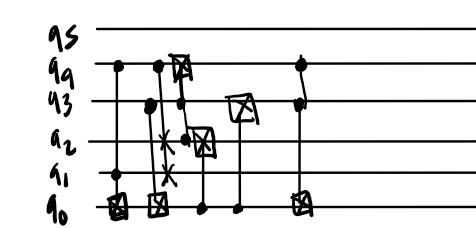 

### x=29  

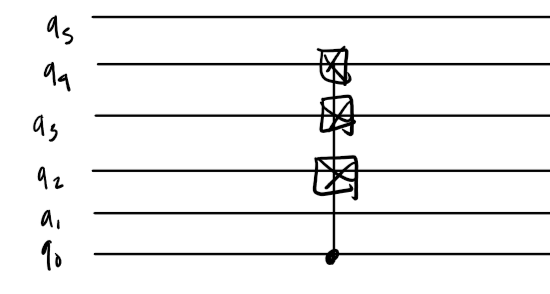

### x=31  

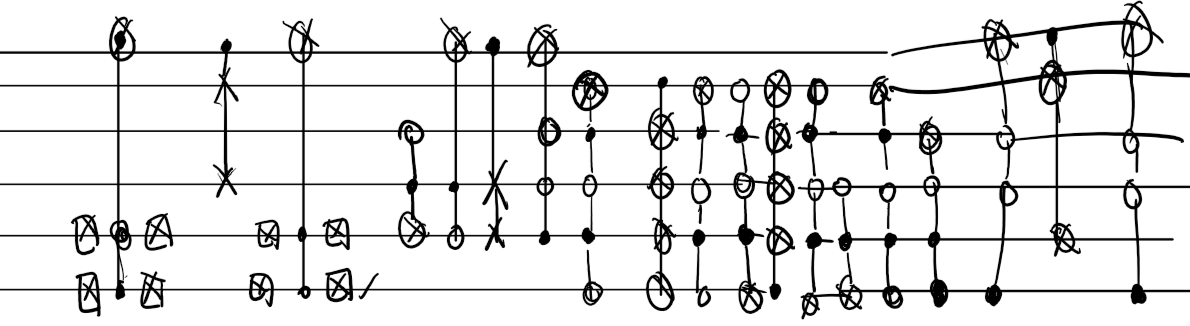 



